In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import precision_recall_fscore_support, make_scorer, recall_score, f1_score, confusion_matrix, precision_score, balanced_accuracy_score
from sklearn.metrics import fbeta_score, classification_report


from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from libs.print_cm import print_cm
from libs.loader import load_malicious

         

from sklearn.model_selection import learning_curve, validation_curve

In [3]:
# df = pd.read_csv("data/malicious_01.csv")
# Xdf = df.drop(columns=["INCIDENT_ID","DATE", "MALICIOUS_OFFENSE"])
# y_mal = df["MALICIOUS_OFFENSE"]
# Xdf['X_12'] = np.nan_to_num(Xdf['X_12'])
# _X, _y = Xdf.values, y_mal.values

# minMaxNorm = MinMaxScaler()
# X = minMaxNorm.fit_transform(_X)
# # pd.DataFrame(X)

# labelEncoder = LabelEncoder()
# y_pre = labelEncoder.fit_transform(_y)
# y = 1 - y_pre
# pd.DataFrame({'y':y,'y2':y_pre})

X, y = load_malicious()


In [4]:
dt = DecisionTreeClassifier(random_state=0)

# scorer = make_scorer(precision_score, pos_label=0 )
scorer = make_scorer(recall_score, pos_label=1)
# scorer = make_scorer(recall_score,average='weighted')
# scorer = make_scorer(f1_score, average='weighted' )
# scorer = make_scorer(f1_score, pos_label=1)


cv_target = cross_validate(dt, X, y, cv=3, scoring=scorer)
cv_target

{'fit_time': array([0.01613617, 0.01347995, 0.01314807]),
 'score_time': array([0.00306368, 0.00315404, 0.00281191]),
 'test_score': array([0.96254682, 0.9588015 , 0.95505618])}

In [18]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y,random_state=0)
dt.fit(X_train,y_train)
pass

In [19]:
def stats_pac( label, estimator, X_data, y_data ):
    predicted = estimator.predict(X_data)
    print ('****** %s ******' % label)
    cm = confusion_matrix(y_data, predicted)
    print ('Confusion matrix')
    print_cm(cm, labels=['0','1'])
    
    print ('Recall - label 0: %0.4f'% recall_score(y_data, predicted, pos_label=0))
    print ('Recall - label 1: %0.4f'% recall_score(y_data, predicted))

    print ('Precsion - label 0: %0.4f'% precision_score(y_data, predicted, pos_label=0))
    print ('Precsion - label 1: %0.4f'% precision_score(y_data, predicted))
    
    sample_wt = [ 3 if i == 1 else 1 for i in predicted]
    print ('F1 Score macro: %0.4f'% f1_score(y_data, predicted, average='macro', sample_weight=sample_wt ))
    print ('F1 Score - label 0 : %0.4f'% f1_score(y_data, predicted, pos_label=0 ))
    print ('F1 Score - label 1 : %0.4f'% f1_score(y_data, predicted, pos_label=1 ))
    print ('F1 Score - weighted avg : %0.4f'% f1_score(y_data, predicted, average='weighted' ))
    print ('F1 Beta - b=2 weighted avg : %0.4f'% fbeta_score(y_data,predicted, average='weighted', beta=2))
    
    print (classification_report(y_data, predicted, labels=[1,0]))


stats_pac('DT plain - Train', dt, X_train, y_train)
stats_pac('TD plain - Validation', dt, X_test, y_test)

****** DT plain - Train ******
Confusion matrix
              0     1 
        0 13672     0 
        1     0   641 
Recall - label 0: 1.0000
Recall - label 1: 1.0000
Precsion - label 0: 1.0000
Precsion - label 1: 1.0000
F1 Score macro: 1.0000
F1 Score - label 0 : 1.0000
F1 Score - label 1 : 1.0000
F1 Score - weighted avg : 1.0000
F1 Beta - b=2 weighted avg : 1.0000
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       641
           0       1.00      1.00      1.00     13672

    accuracy                           1.00     14313
   macro avg       1.00      1.00      1.00     14313
weighted avg       1.00      1.00      1.00     14313

****** TD plain - Validation ******
Confusion matrix
              0     1 
        0  3414     5 
        1     4   156 
Recall - label 0: 0.9985
Recall - label 1: 0.9750
Precsion - label 0: 0.9988
Precsion - label 1: 0.9689
F1 Score macro: 0.9887
F1 Score - label 0 : 0.9987
F1 Score - label 1 : 0.9720

## Try CPP alpha

In [20]:
dt = DecisionTreeClassifier(random_state=0)
path = dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

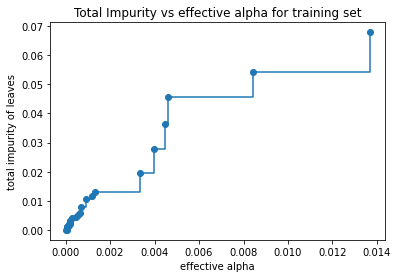

In [21]:

axs = plt.gca()
axs.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
axs.set_xlabel("effective alpha")
axs.set_ylabel("total impurity of leaves")
axs.set_title("Total Impurity vs effective alpha for training set")

In [22]:
ccp_alphas_range = ccp_alphas[:-1]

In [24]:
def node_counts(ccp_alphas):
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y,random_state=0)
    clfs, x, yn, yd= [],[],[],[]
    plot_data = np.zeros((len(ccp_alphas),2))
    for i in range(len(ccp_alphas)):
        clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alphas[i])
        clf.fit(X_train, y_train)
        clfs.append(clf)
#         print(f"alpha:{ccp_alphas[i]}, node_cnt:{clf.tree_.node_count}")
        x.append( ccp_alphas[i] )
        yn.append(clf.tree_.node_count)
        yd.append(clf.tree_.max_depth)
    return yn, yd
    
#     axs = plt.gca()
#     axs.scatter(plot_data[:,0], plot_data[:,1])

In [35]:
def v_curve(estimator, param_name, range_list, title):
    strat_cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

    mlp_train_scores, mlp_test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=range_list,
        scoring=scorer, cv=strat_cv, n_jobs=-1)
    
    train_scores_mean = np.mean(mlp_train_scores, axis=1)
    test_scores_mean = np.mean(mlp_test_scores, axis=1)
    print (len(range_list),train_scores_mean.shape,test_scores_mean.shape)
    df_1 = pd.DataFrame({'x':range_list,'train':train_scores_mean,'test':test_scores_mean} )
    print(df_1)
    
    yn, yd = node_counts(range_list)
    
    
    fig = plt.figure(figsize=[7,5])
    axs = fig.add_subplot(111)
    
    twin1 = axs.twinx()
    p1, = axs.plot(df_1['x'], df_1['train'], label='Train', linewidth=0.75, marker='.')
    p2, = axs.plot(df_1['x'], df_1['test'], label='Validation', linewidth=0.75, marker='.')
    c_pur = 'Purple'
    p3 = twin1.scatter(df_1['x'], yd, label='Tree depth', c=c_pur, marker='.')
    max_id_series = df_1.idxmax(axis=0)
    print(max_id_series)
    max_id = max_id_series['test']
    print(type(max_id_series))
    print(f"max_id {max_id}")
    best_alpha = df_1.at[max_id, 'x']; alpha_label = 'CCP Alpha %0.5f'%best_alpha
    p4 = axs.axvline(best_alpha, color='g', linewidth=0.85, label=alpha_label)
    
    
    twin1.set_ylabel('Tree Depth')
    twin1.tick_params(axis='y', colors=c_pur)
    twin1.yaxis.label.set_color(c_pur)
    axs.legend(handles=[p1,p2,p3,p4]); axs.set_ylabel("Metric: Recall"); axs.set_xlabel(title)
    axs.set_title(title)

In [68]:
# depth_stuff = node_counts(ccp_alphas[:15])

15 (15,) (15,)
           x     train      test
0   0.000000  1.000000  0.973804
1   0.000045  1.000000  0.973804
2   0.000056  1.000000  0.973804
3   0.000064  1.000000  0.973804
4   0.000065  1.000000  0.973804
5   0.000068  0.998128  0.972554
6   0.000069  0.998128  0.973804
7   0.000070  0.997191  0.973804
8   0.000075  0.997191  0.973804
9   0.000075  0.997191  0.973804
10  0.000116  0.994383  0.975047
11  0.000118  0.993759  0.973797
12  0.000121  0.993759  0.973797
13  0.000136  0.991886  0.975047
14  0.000140  0.991574  0.973797
x        14
train     0
test     13
dtype: int64
<class 'pandas.core.series.Series'>
max_id 13


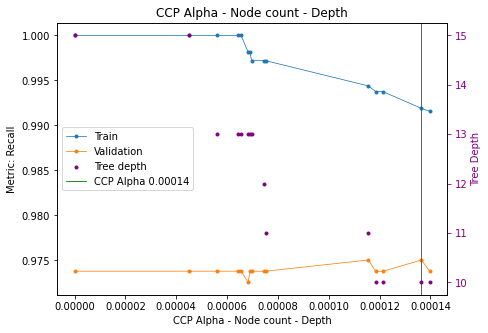

In [36]:
v_curve(dt, 'ccp_alpha', ccp_alphas_range[:15], 'CCP Alpha - Node count - Depth')

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 0,
 'splitter': 'best'}

In [4]:
dt_target = DecisionTreeClassifier(ccp_alpha=0.00018, min_samples_leaf=1)

dt_target.fit(X,y)

DecisionTreeClassifier(ccp_alpha=0.00018)

[Text(732.375, 1467.72, 'X[9] <= 1.5\ngini = 0.086\nsamples = 17892\nvalue = [17091, 801]'),
 Text(348.75, 1141.56, 'X[14] <= 35.0\ngini = 0.01\nsamples = 15185\nvalue = [15105, 80]'),
 Text(209.25, 815.4000000000001, 'X[14] <= 13.5\ngini = 0.001\nsamples = 13100\nvalue = [13095, 5]'),
 Text(139.5, 489.24, 'X[14] <= 4.5\ngini = 0.014\nsamples = 725\nvalue = [720, 5]'),
 Text(69.75, 163.08000000000015, '\n  (...)  \n'),
 Text(209.25, 163.08000000000015, '\n  (...)  \n'),
 Text(279.0, 489.24, 'gini = 0.0\nsamples = 12375\nvalue = [12375, 0]'),
 Text(488.25, 815.4000000000001, 'X[14] <= 39.5\ngini = 0.069\nsamples = 2085\nvalue = [2010, 75]'),
 Text(418.5, 489.24, 'gini = 0.0\nsamples = 75\nvalue = [0, 75]'),
 Text(558.0, 489.24, 'gini = 0.0\nsamples = 2010\nvalue = [2010, 0]'),
 Text(1116.0, 1141.56, 'X[11] <= 1.5\ngini = 0.391\nsamples = 2707\nvalue = [1986, 721]'),
 Text(837.0, 815.4000000000001, 'X[11] <= 0.5\ngini = 0.447\nsamples = 630\nvalue = [212, 418]'),
 Text(697.5, 489.24, 'X[

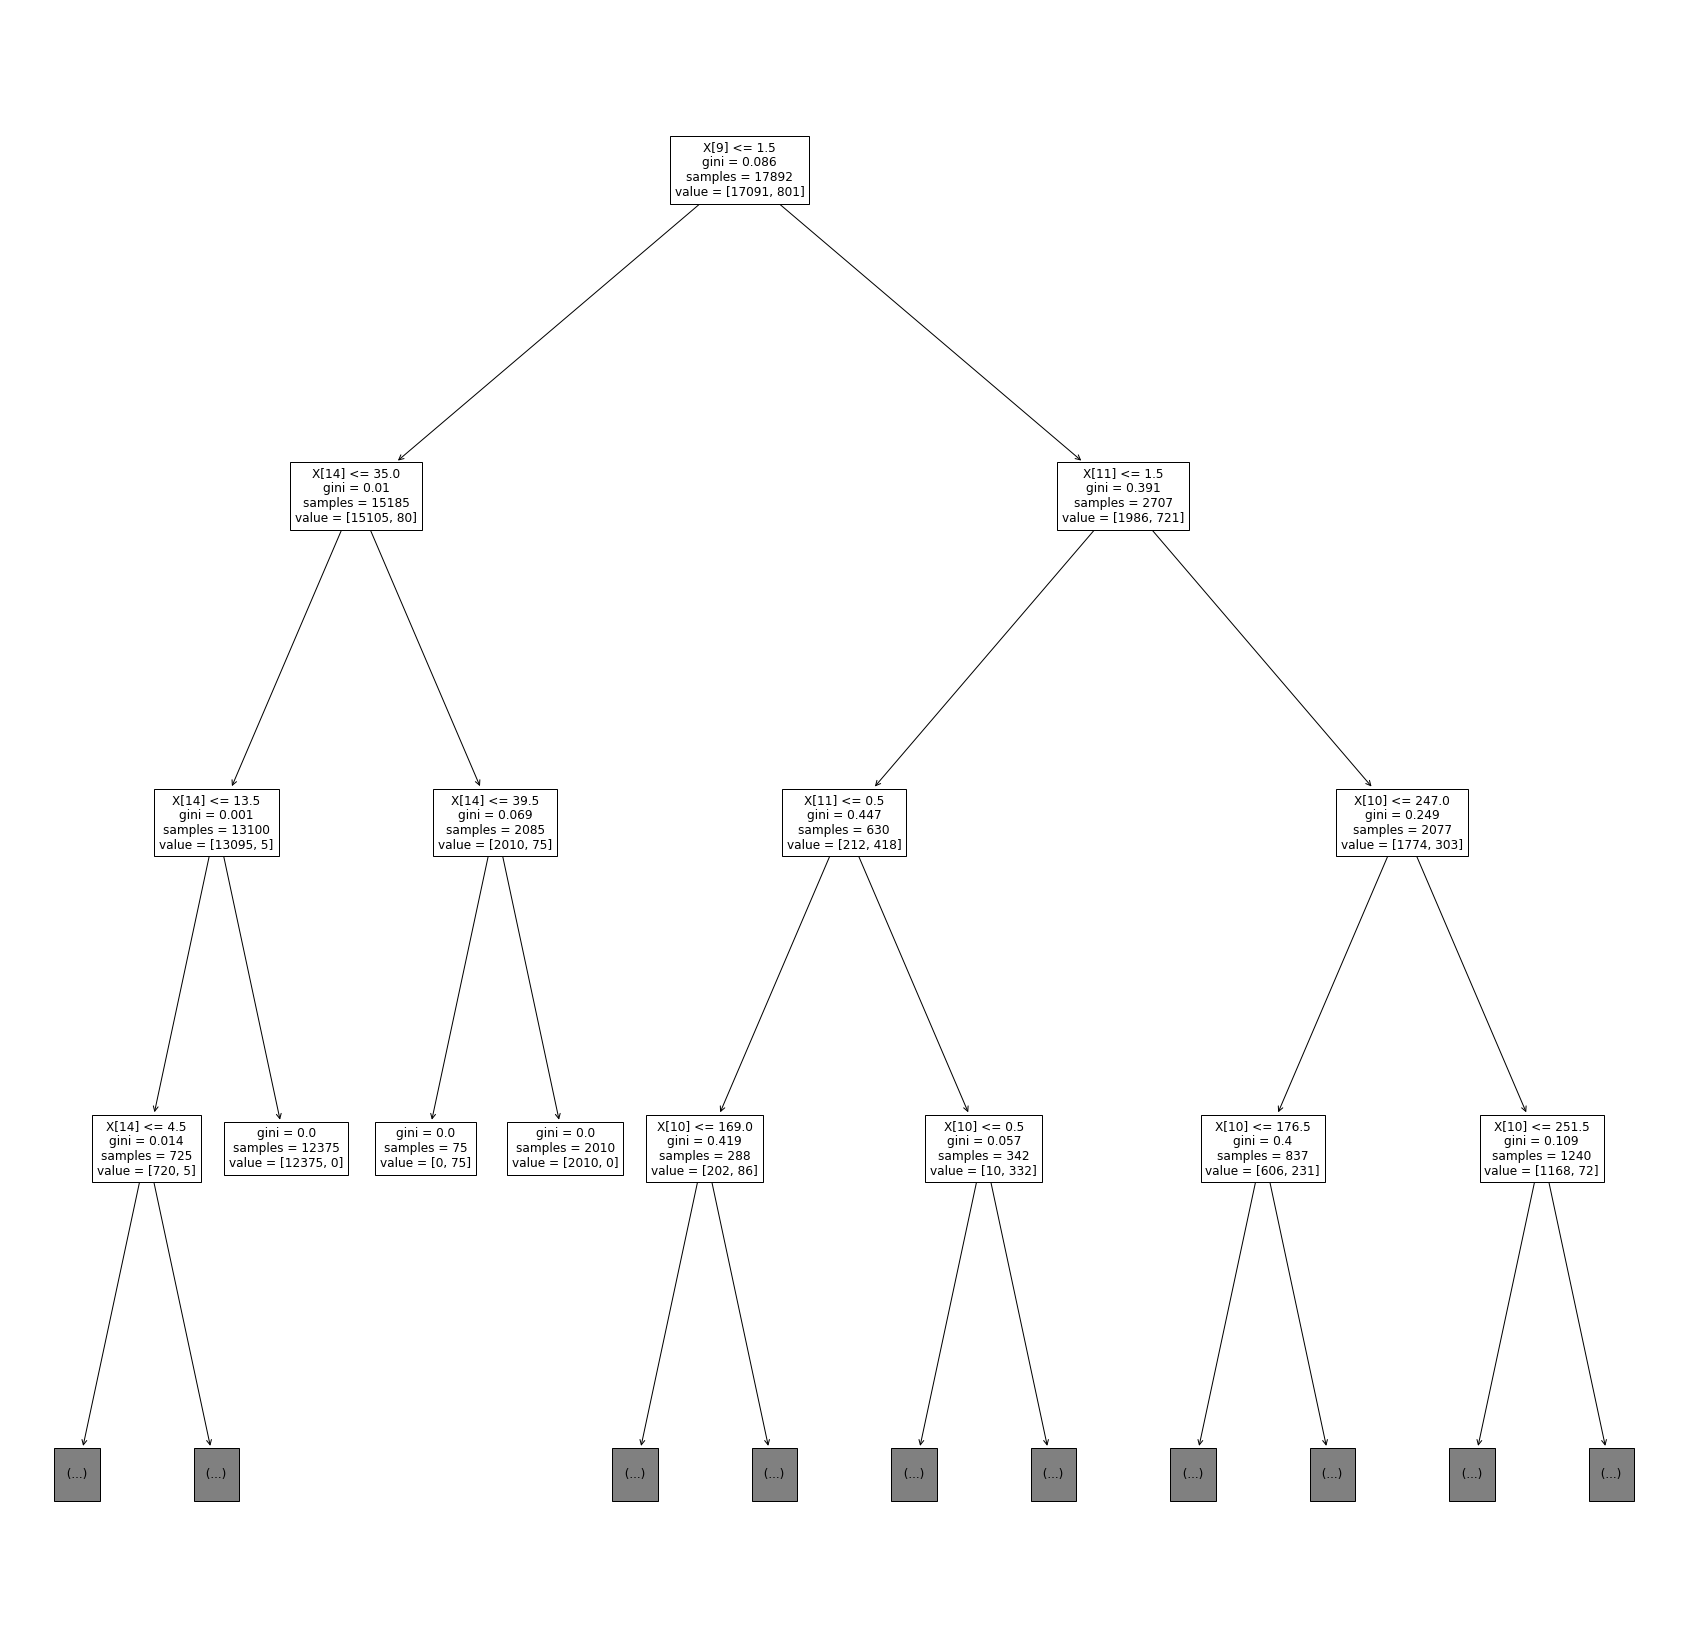

In [5]:
fig = plt.figure(figsize=[30,30])
axs1 = fig.add_subplot(111)
plot_tree(dt_target, max_depth=3, ax=axs1)